# Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (and make it a script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (an example is shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarify and explain them.
* Make sure that **number cells are consecutive starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells` as often as needed.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Multilayer Perceptron Modelling

## The `housing` problem

We want to predict average house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import time
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.datasets import fetch_openml

import seaborn as sns

## Carga de datos

In [4]:
boston_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', \
                'MEDV']
source = 'openml'
    
if source == 'uci':
    print("reading from the uci site ...")
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    df_housing_u = raw_df
    df_housing_u.columns = boston_names
    
elif source == 'cmu':
    print("reading from the cmu site ...")
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

    df_data = pd.DataFrame(data=data)
    df_target = pd.DataFrame(data=target)
    df_housing_c = pd.concat([df_data, df_target], axis=1)
    df_housing_c.columns = boston_names
    
elif source == 'openml':
    print("loading from openml datasets  ...")
    # Fetch the Boston housing dataset
    boston = fetch_openml(name='boston', version=1, parser='auto')
    df_housing_o = pd.DataFrame(data=boston['data'], columns=boston['feature_names']).astype('float')
    df_housing_o['MEDV'] = boston['target']
    
vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                      'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
target_housing = ['MEDV']

loading from openml datasets  ...


In [5]:
df_housing = df_housing_o

vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                      'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
target_housing = ['MEDV']

## Visualización y correlaciones

### Boxplots

Boxplots, histogramas y visualizaciones sobre valores normalizados

In [ ]:
df_housing.describe().T

### Boxplots and histograms

In [ ]:
#normalizar para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing_normalizado)
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Plot histograms of groups of 5 variables plus target.

In [ ]:
pair_plot = sns.pairplot( df_housing[ list(vars_housing[ : 5]) + [target_housing] ] )
plt.show()

In [ ]:
pair_plot = sns.pairplot( df_housing[ list(vars_housing[ 5: 10]) + [target_housing] ] )
plt.show()

In [ ]:
pair_plot = sns.pairplot( df_housing[ list(vars_housing[ 10: -1]) + [target_housing] ] )
plt.show()

### Correlations

In [ ]:
df_housing.corr().round(decimals=3)

In [ ]:
#correlation heatmap

cMap = plt.cm.get_cmap("bwr",lut=9) 

plt.figure( figsize=(10, 8))
plt.title('housing correlations')
_ = sns.heatmap(df_housing.corr().values, vmin=-1., vmax=1., cmap=cMap, 
                xticklabels=list(df_housing.columns),
                yticklabels=list(df_housing.columns))

## MLPs

In [6]:
sc = StandardScaler()

x = sc.fit_transform( df_housing[ vars_housing ] )
y = df_housing[ target_housing ].values.reshape(-1, )

### Define and fit a first MLP

In [7]:
hidden_layer_sizes = (20, 20)
alpha = 0.
s_size = x.shape[0]

#solver: lbfgs para problemas pequeños, adam para problemas grandes
mlp_m =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      activation='relu', 
                      solver='lbfgs',
                      batch_size=s_size // 10,
                      alpha=alpha,
                      #early_stopping=True,
                      tol=1.e-6, 
                      max_iter=5000)

mlp_m.fit(x, y)

C:\Users\josed\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.0, batch_size=50, hidden_layer_sizes=(20, 20),
             max_iter=5000, solver='lbfgs', tol=1e-06)

In [8]:
from scipy.stats import median_abs_deviation 
from sklearn.metrics import r2_score, mean_squared_error

y_p = mlp_m.predict(x)
err = np.abs(y - y_p)

#print(median_abs_deviation(err) / np.median(err))
print(1. - median_abs_deviation(err) / np.median(np.abs(y - np.median(y))))
print(1. - np.median(err) / np.median(np.abs(y - np.median(y))))
print(1. - mean_absolute_error(y, y_p) / median_abs_deviation(y))
print(1. - mean_absolute_error(y, y_p) / mean_absolute_error(y, np.median(y) * np.ones(len(y))))

print(r2_score(y, y_p))
1 - mean_squared_error(y, y_p) / y.var()

0.9605972761220638
0.9464309729275933
0.9117811259762598
0.9459677416255976
0.9963432068285263


0.9963432068285263

What do we have in mlp_m?

In [9]:
print("weight_structure")
print(mlp_m.coefs_[0].shape)
print(mlp_m.coefs_[1].shape)
print(mlp_m.coefs_[2].shape)

print("mlp_loss: %.3f" % mlp_m.loss_)

weight_structure
(12, 20)
(20, 20)
(20, 1)
mlp_loss: 0.154


#### Predict and evaluate by CV

MAE: 0.353


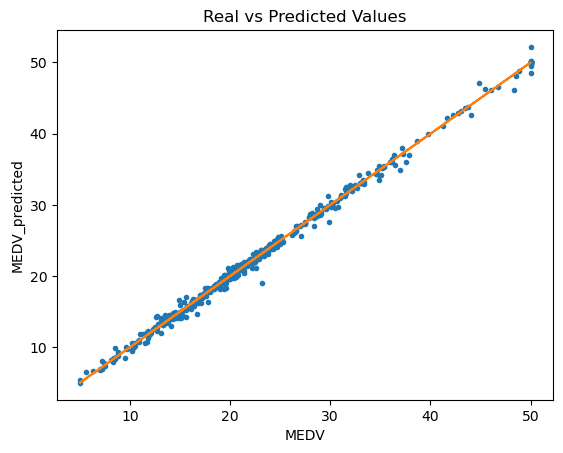

In [10]:
from sklearn.metrics import mean_absolute_error

y_pred = mlp_m.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

A clear case of overfitting and of bad model performance evaluation!!

CV gives us a more sensible evaluation.

In [11]:
n_folds = 5
kf = KFold(n_folds, shuffle=True)

scores_mlp = cross_val_score(mlp_m, x, y.ravel(), scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

In [12]:
print( ("mae_mean: %.3f" % -scores_mlp.mean()),  ("\tmae_std: %.3f" % scores_mlp.std()) )
print("scores:\n", -np.round(scores_mlp, 3))

mae_mean: 3.893 	mae_std: 0.244
scores:
 [4.018 3.983 3.514 4.215 3.733]


#### Analyze CV predictions

In [13]:
from sklearn.model_selection import cross_val_predict

y_pred_mlp_cv = np.clip( cross_val_predict(mlp_m, x, y.ravel(), cv=kf), 5., 50.)

C:\Users\josed\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\josed\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\josed\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

3.9158596713327922


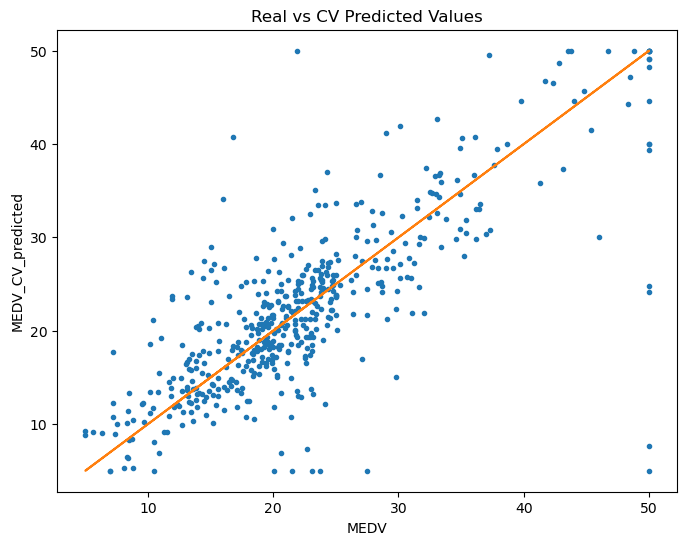

In [14]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

print(mean_absolute_error(y, y_pred_mlp_cv))

### Finding the optimal `alpha` by CV

We first improve on our definition of the mlp using a pipeline and scaling targets and then select the l2 penalty parameter `alpha` by CV.

We will exploit the model available in the `GridSearchCV` object.

In [15]:
#redefine x, now without scaling
x = df_housing[ vars_housing ].values

# select alpha in mlp regression by CV
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)

mlpr =  MLPRegressor(activation='relu', 
                     solver='adam', 
                     #batch_size=s_size//10,
                     #solver='lbfgs', 
                     early_stopping=False,
                     tol=1.e-10, 
                     max_iter=10000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])
    
y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-9, 2)]
param_grid = {'regressor__mlp__alpha': l_alpha,  
              'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a joblib file    
f_cv = 'mlp_alpha_search_results.joblib'
joblib.dump(cv_estimator, f_cv)

Fitting 5 folds for each of 33 candidates, totalling 165 fits

mlp_grid_search_time: 0.34


['mlp_alpha_search_results.joblib']

alpha_range: 0.0000000010 - 10.000000
best_alpha = 0.0000000010
best_hidden_layer_sizes (20, 20, 20)
best_cv_mae = 2.351


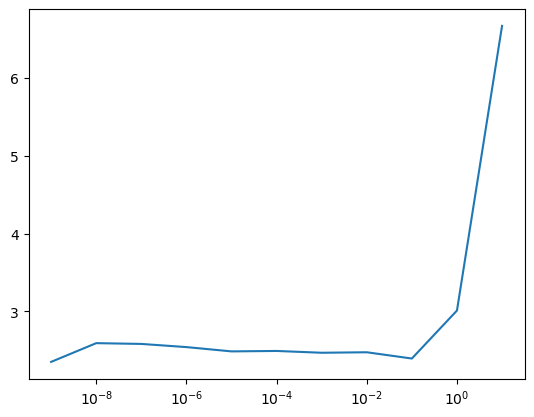

In [16]:
f_cv = 'mlp_alpha_search_results.joblib'
cv_estimator = joblib.load(f_cv)

print("alpha_range: %.10f - %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.10f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_hidden_layer_sizes', (cv_estimator.best_params_['regressor__mlp__hidden_layer_sizes']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

df_cv = pd.DataFrame.from_dict(cv_estimator.cv_results_)
idx_hl = df_cv['param_regressor__mlp__hidden_layer_sizes'] == cv_estimator.best_params_['regressor__mlp__hidden_layer_sizes']

plt.xscale('log')
_ = plt.plot(l_alpha, -df_cv[idx_hl]['mean_test_score'])

In [17]:
df_cv.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                          'param_regressor__mlp__hidden_layer_sizes',\
                                                          'mean_test_score']][ : 5]

,param_regressor__mlp__alpha,param_regressor__mlp__hidden_layer_sizes,mean_test_score
2,0.0,"(20, 20, 20)",-2.351475
26,0.1,"(20, 20, 20)",-2.394545
19,0.001,"(20, 20)",-2.410347
25,0.1,"(20, 20)",-2.427801
20,0.001,"(20, 20, 20)",-2.468821


#### Testing the optimal model

We cross_val_predict several different MLPs with the optimal hyperparameters.

In [19]:
l_preds = []
best_mlp = cv_estimator.best_estimator_

#the larger the number of MLPs, the more stable should be the mean and median errors
for i in range(20):
    print('training mlp ', i)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=200+i)

    y_pred =  np.clip(cross_val_predict(best_mlp, x, y, cv=kf, n_jobs=-1), 5., 50.)
    l_preds.append(y_pred)
    
a_preds = np.array(l_preds).T
mean_y_pred = a_preds.mean(axis=1)
median_y_pred = np.median(a_preds, axis=1)

print("mae_mean_pred {0:9.3f}  ".format(mean_absolute_error(y, mean_y_pred)))
print("mae_median_pred {0:9.3f}".format(mean_absolute_error(y, median_y_pred)))

training mlp  0
training mlp  1
training mlp  2
training mlp  3
training mlp  4
training mlp  5
training mlp  6
training mlp  7
training mlp  8
training mlp  9
training mlp  10
training mlp  11
training mlp  12
training mlp  13
training mlp  14
training mlp  15
training mlp  16
training mlp  17
training mlp  18
training mlp  19
mae_mean_pred     2.198  
mae_median_pred     2.191


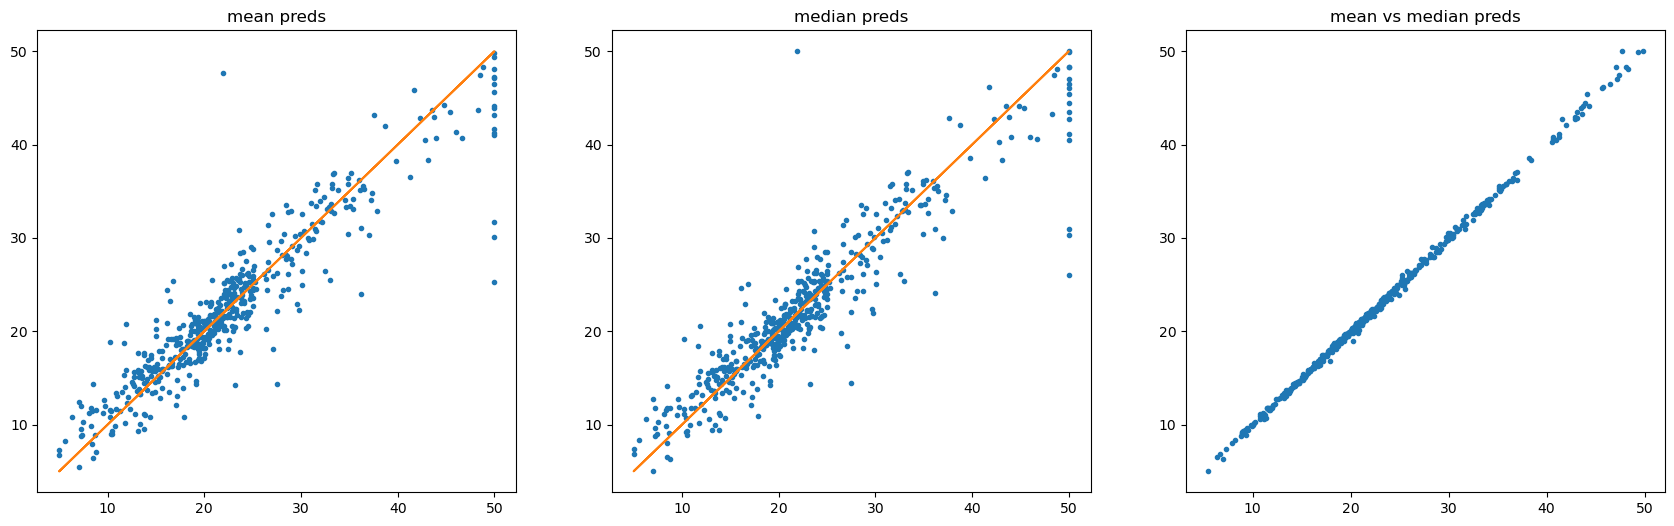

In [20]:
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.title('mean preds')
_ = plt.plot(y, mean_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title('median preds')
_ = plt.plot(y, median_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 3)
plt.title('mean vs median preds')
_ = plt.plot(mean_y_pred, median_y_pred, '.')